# Mondo Rare Disease Analysis


Any disease term in Mondo is characterized as 'rare' if the term or its ancestor has modifier MONDO:0021136 'Rare'.

In [1]:
disease_term = 'MONDO:0000001'
rare_term = 'MONDO:0021136'
disease_susceptibility_term = 'MONDO:0042489'

SUBCLASS_OF = 'subClassOf'
HAS_MODIFIER = 'RO:0002573'

In [2]:
from ontobio.ontol_factory import OntologyFactory
ofa = OntologyFactory()
ont = ofa.create('ontology/mondo.json') # http://purl.obolibrary.org/obo/mondo/releases/2019-09-30/mondo.json
subont = ont.subontology(relations=['subClassOf', 'RO:0002573'])
subclass_subont = ont.subontology(relations=['subClassOf'])

In [3]:
disease_terms = subclass_subont.descendants('MONDO:0000001')

In [4]:
print("Number of Mondo terms that are descendants of MONDO:0000001 'Disease': {}".format(len(disease_terms)))

Number of Mondo terms that are descendants of MONDO:0000001 'Disease': 21633


In [5]:
disease_susceptibility_descendants = subont.descendants(disease_susceptibility_term)

In [6]:
print("Number of Mondo terms that are descendants of MONDO:0042489 'disease susceptibility': {}".format(len(disease_susceptibility_descendants)))

Number of Mondo terms that are descendants of MONDO:0042489 'disease susceptibility': 249


In [7]:
disease_terms_filtered = [x for x in disease_terms if x not in disease_susceptibility_descendants]

In [8]:
print("Number of Mondo disease terms that are not descendants of MONDO:0042489 'disease susceptibility': {}".format(len(disease_terms_filtered)))

Number of Mondo disease terms that are not descendants of MONDO:0042489 'disease susceptibility': 21563


In [9]:
rare_disease_terms = set()

for x in disease_terms_filtered:
    # we consider a disease term to be a rare disease term if and only if 'MONDO:0021136' is its ancestor
    if rare_term in subont.ancestors(x):
        rare_disease_terms.add(x)

In [10]:
print("Number of Mondo disease terms that are rare: {}".format(len(rare_disease_terms)))

Number of Mondo disease terms that are rare: 12914


In [11]:
gard_rare_subset = ont.extract_subset('gard_rare')

In [12]:
# Filter term 'gard_rare' subset to only those that are descendants of 'MONDO:0000001'
gard_rare_subset_filtered = [x for x in gard_rare_subset if x in disease_terms]

In [13]:
print("Number of Mondo disease terms that are in GARD rare subset: {}".format(len(gard_rare_subset_filtered)))

Number of Mondo disease terms that are in GARD rare subset: 3176


In [14]:
rare_disease_gard_subset = set()
rare_disease_gard_subset.update(rare_disease_terms)
rare_disease_gard_subset.update(gard_rare_subset_filtered)

In [15]:
print("Number of Mondo rare disease terms that are also in gard_rare subset: {}".format(len(rare_disease_gard_subset)))

Number of Mondo rare disease terms that are also in gard_rare subset: 13867


In [16]:
rare_disease_gard_subset_filtered = set()
for term in rare_disease_gard_subset:
    if term not in disease_susceptibility_descendants:
        rare_disease_gard_subset_filtered.add(term)

In [17]:
print("Number of rare disease terms that are also in gard_rare subset and not a descendant of MONDO:0042489 'disease susceptibility': {}".format(len(rare_disease_gard_subset_filtered)))

Number of rare disease terms that are also in gard_rare subset and not a descendant of MONDO:0042489 'disease susceptibility': 13866


In [18]:
rare_disease_gard_subset_filtered_leaf_nodes = set()

for term in rare_disease_gard_subset_filtered:
    descendants = subont.descendants(term)
    if len(descendants) == 0:
        rare_disease_gard_subset_filtered_leaf_nodes.add(term)

In [19]:
print("Number of Mondo rare disease terms that are leaf nodes in the ontology: {}".format(len(rare_disease_gard_subset_filtered_leaf_nodes)))

Number of Mondo rare disease terms that are leaf nodes in the ontology: 10394


In [20]:
from collections import defaultdict

mondo_disease_term = 'MONDO:0000001'
all_disease_descendants = subclass_subont.descendants(mondo_disease_term)

all_leaf_nodes = []
is_leaf = []
is_rare = []
is_gard_rare = []
is_mondo_rare = []
term_xrefs = {}
term_synonyms = {}

for term in all_disease_descendants:
    if term in rare_disease_gard_subset_filtered_leaf_nodes:
        is_leaf.append(True)
    else:
        is_leaf.append(False)

    if term in rare_disease_gard_subset_filtered:
        is_rare.append(True)
    else:
        is_rare.append(False)

    if term in rare_disease_terms:
        is_mondo_rare.append(True)
    else:
        is_mondo_rare.append(False)

    if term in gard_rare_subset_filtered:
        is_gard_rare.append(True)
    else:
        is_gard_rare.append(False)

    xrefs = ont.xrefs(term)
    term_xrefs[term] = defaultdict(str)
    for xref in xrefs:
        if xref.startswith('GARD:'):
            term_xrefs[term]['GARD'] = xref
        elif xref.startswith('NCIT:'):
            term_xrefs[term]['NCIT'] = xref
        elif xref.startswith('OMIM:'):
            term_xrefs[term]['OMIM'] = xref
        elif xref.startswith('DOID:'):
            term_xrefs[term]['DOID'] = xref
        elif xref.startswith('Orphanet:'):
            term_xrefs[term]['Orphanet'] = xref

    synonyms = [x.val for x in ont.synonyms(term)]
    term_synonyms[term] = synonyms

In [21]:
import pandas as pd
import collections
import itertools

from matplotlib import pyplot as plt

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def makebool(combo, cols):
    return [c in combo for c in cols]

# https://upsetplot.readthedocs.io/en/latest/api.html
import upsetplot as usp
counts_dict = {}

def create_upset(df, cols, count_limit=0, **args):
    ps = powerset(cols)
    global my_data
    counts_by_combo = collections.defaultdict(int)
    for i,r in df.iterrows():
        combo = [r[c] != "" and r[c] != False and r[c] != 0 for c in cols]
        counts_by_combo[tuple(combo)] += 1
    
    for k,v in counts_by_combo.items():
        key = []
        for i in range(0,len(cols)):
            if k[i]:
                key.append(cols[i])
        key_str = '-'.join(key)
        counts_dict[key_str] = v

    counts = []
    boolvecs = []
    for s in ps:
        boolvec = makebool(s, cols)
        c = counts_by_combo[tuple(boolvec)]
        if c > count_limit:
            boolvecs.append(boolvec)
            counts.append(c)
    multiindex = pd.MultiIndex.from_tuples(boolvecs, names=cols)
    upsetdata = pd.Series(counts, index=multiindex).sort_values(ascending=False)
    my_data = upsetdata
    usp.plot(upsetdata, sort_by='cardinality', **args)


In [22]:
d = {
    'class': all_disease_descendants,
    'class_label': [ont.label(x) for x in all_disease_descendants],
    'synonyms': ['|'.join(term_synonyms[x]) for x in all_disease_descendants],
    'GARD': [term_xrefs[x]['GARD'] for x in all_disease_descendants],
    'NCIT': [term_xrefs[x]['NCIT'] for x in all_disease_descendants],
    'OMIM': [term_xrefs[x]['OMIM'] for x in all_disease_descendants],
    'DOID': [term_xrefs[x]['DOID'] for x in all_disease_descendants],
    'Orphanet': [term_xrefs[x]['Orphanet'] for x in all_disease_descendants],
    'is_gard_rare': is_gard_rare,
    'is_mondo_rare': is_mondo_rare,
    'is_rare': is_rare,
    'is_leaf': is_leaf,
}
df = pd.DataFrame(data=d)

In [23]:
df

,class,class_label,synonyms,GARD,NCIT,OMIM,DOID,Orphanet,is_gard_rare,is_mondo_rare,is_rare,is_leaf
0,MONDO:0008454,spinal intradural arachnoid cysts,spinal intradural arachnoid cysts|arachnoid cy...,GARD:0009701,,OMIM:182990,,,True,True,True,True
1,MONDO:0013138,BRV2,"vertigo, benign recurrent, 2; BRV2|BRV2|vertig...",,,OMIM:613106,,,False,True,True,True
2,MONDO:0009717,Schwartz-Jampel syndrome,"Schwartz-Jampel syndrome, type 1; SJS1|Schwart...",GARD:0000250,NCIT:C35008,OMIM:255800,DOID:0090005,Orphanet:800,False,True,True,True
3,MONDO:0010765,"46,XY complete gonadal dysgenesis","46,XY CGD|Swyer syndrome|46,XY SEX reversal|46...",GARD:0005068,NCIT:C120198,,DOID:14448,Orphanet:242,False,True,True,False
4,MONDO:0011996,"chronic myelogenous leukemia, BCR-ABL1 positive",chronic granulocytic leukemia|myeloid leukemia...,GARD:0006105,NCIT:C3174,OMIM:608232,DOID:8552,Orphanet:521,False,True,True,False
5,MONDO:0003426,clear cell adenoma,clear cell adenoma (morphologic abnormality)|a...,,NCIT:C4151,,DOID:5390,,False,False,False,False
6,MONDO:0016917,partial deletion of the long arm of chromosome 19,partial monosomy of the long arm of chromosome...,,,,,Orphanet:262155,False,True,True,False
7,MONDO:0017466,congenital pseudoarthrosis of the ulna,congenital pseudarthrosis of the ulna,,,,,Orphanet:295026,False,True,True,True
8,MONDO:0011766,"46,XY gonadal dysgenesis-motor and sensory neu...","46,XY gonadal dysgenesis, partial, with MINIFA...",,,OMIM:607080,,Orphanet:168563,False,True,True,True
9,MONDO:0006685,brain hypoxia - ischemia,,,,,,,False,False,False,False


In [24]:
df.to_csv('artifacts/all-mondo-disease-terms.tsv', sep='\t', index=False)

### Rare and leaf MONDO terms


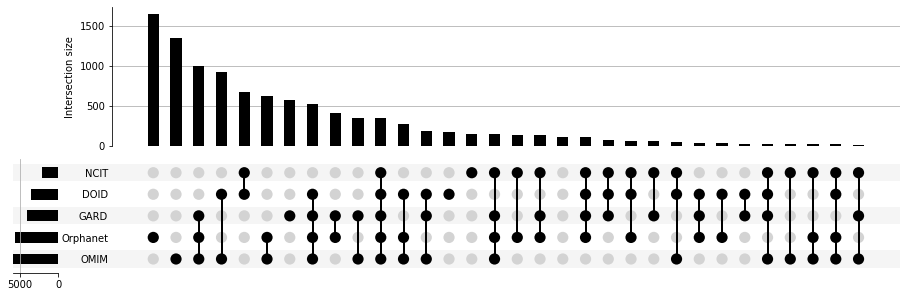

In [25]:
# rare and leaf Mondo terms
df4 = df.loc[(df['is_rare'] == True) & (df['is_leaf'] == True)]
create_upset(df4, ['GARD', 'NCIT', 'OMIM', 'DOID', 'Orphanet'])

In [26]:
df4.to_csv('artifacts/rare-and-leaf-mondo-disease-terms.tsv', sep='\t', index=False)